In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
import joblib

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

Lectura de datos desde .csv

In [3]:
#Lectura de plantas y creación de lista con DataFrames

directory_path = "C:\\Users\\franc\\OneDrive\\Documentos\\VScode\\Github\\Franico-proyecto\\dataset\\"

files_names = [file for file in os.listdir(directory_path)]

df_list = []

for name in files_names:
    df_list.append(pd.read_csv(directory_path + name))

Funciones útiles a utilizar

In [9]:
#Funciones a utilizar

def extract_samples(dataframe, cutting = 0, test = False):
    '''Función para extraer los vectores de generación para cada dataframe'''

    values = dataframe["muestra"].unique()
    samples, labels, poa = [], [], []
    scaler = StandardScaler()

    for i in values:
        l_df = dataframe[dataframe["muestra"] == i]
        if np.isnan(l_df["generacion"].values).any() == True:
            continue

        #Cortar valores (test)
        v_gen = l_df["generacion"].values
        v_clip = l_df["clipping"].values
        v_poa = l_df["poa"].values

        #### Debo arreglar esto (eficiencia) ####
        for i in range(cutting):
            v_gen = v_gen[4:-2]
            v_clip = v_clip[4:-2]
            v_poa = v_poa[4:-2]

        if test == True:
            dif = np.array(v_gen) - np.array(v_poa)
            normalized_gen = scaler.fit_transform(dif.reshape(-1, 1))
            matriz = normalized_gen
        
        else:
            normalized_gen = scaler.fit_transform(np.array(v_gen).reshape(-1, 1))
            normalized_poa = scaler.fit_transform(np.array(v_poa).reshape(-1, 1))
            matriz = np.array([normalized_gen, normalized_poa])
            matriz = matriz.T

        samples.append(matriz)
        labels.append(v_clip)
    return samples, labels


def error_threshold(predict_vector, test_label, error_tolerance):
    '''Función para obtener vectores predichos con cierta cantidad de errores'''

    error = []
    error_vector = []

    for i,j in zip(predict_vector, test_label):
        if (i != j).any():
            error.append([i,j])

        if list(i == j).count(False) == error_tolerance:
            error_vector.append([i, j])
    
    return error, error_vector

Creación de dataset y vectores de entrenamiento y test

In [10]:

generation = []
label = []

for d_frame in df_list:
    result = extract_samples(d_frame, cutting = 1)
    for i, j in zip(result[0], result[1]):
        generation.append(i)
        label.append(j)

x_train, x_test, y_train, y_test = train_test_split(generation, label, test_size=0.3, random_state=0)

In [12]:
x_train_flat = np.array([x.flatten() for x in x_train])
x_test_flat = np.array([x.flatten() for x in x_test])

In [77]:
modelo = RandomForestClassifier(n_estimators = 150, min_samples_split = 2, min_samples_leaf = 2, max_depth = 25, bootstrap = False)
vector = [i[:18] for i in x_train_flat]
vector_test = [i[:18] for i in x_test_flat]
modelo = modelo.fit(vector, y_train)
prediccion = modelo.predict(vector_test)

print(accuracy_score(prediccion, y_test))
print("")

lista1 = error_threshold(prediccion, y_test, 1)
lista2 = error_threshold(prediccion, y_test, 2)
prediccion = modelo.predict(vector_test)
pre = accuracy_score(prediccion, y_test)

print("total de predicciones:", len(x_test))
print("Total de vector con 1 error:", len(lista1[1]))
print("Total de vector con 2 error:", len(lista2[1]))
print("")

print("Precision con 1 error:", (len(lista1[1]) + pre*len(x_test))/len(x_test))
print("Precision con 2 error:", (len(lista1[1]) + len(lista2[1]) + pre*len(x_test))/len(x_test))

0.7294523879000098

total de predicciones: 20562
Total de vector con 1 error: 4288
Total de vector con 2 error: 1058

Precision con 1 error: 0.9379924131893784
Precision con 2 error: 0.9894465518918393


In [74]:
a = [1,2,3,4,5]

a[:4]

[1, 2, 3, 4]

In [57]:
#Entrenamiento del modelo

depth = [10, 20, 30, 40, 50, 100, 300, 500]

for i in depth:
    modelo = RandomForestClassifier(n_estimators = i)
    modelo = modelo.fit(x_train, y_train)
    prediccion = modelo.predict(x_test)
    print("Accuracy:", accuracy_score(prediccion, y_test))
    prediccion = modelo.predict(x_train)
    print("Sobreajuste:", accuracy_score(prediccion, y_train))


Accuracy: 0.6521009629413481
Sobreajuste: 0.9776772687481763
Accuracy: 0.6701196381674934
Sobreajuste: 0.9944557922381091
Accuracy: 0.6746060694484972
Sobreajuste: 0.9978358136368057
Accuracy: 0.6807703530784943
Sobreajuste: 0.9988327983659178
Accuracy: 0.6842354829296761
Sobreajuste: 0.9996838828907694
Accuracy: 0.6869711117595565
Sobreajuste: 0.9999270498978698
Accuracy: 0.6906186168660636
Sobreajuste: 1.0
Accuracy: 0.689779690691567
Sobreajuste: 1.0


In [66]:
modelo = RandomForestClassifier()
param_dist = {
    'n_estimators': np.arange(10, 310, 20),
    'max_depth': [None] + list(np.arange(5, 30, 5)),
    'min_samples_split': np.arange(2, 11),
    'min_samples_leaf': np.arange(1, 11),
    'bootstrap': [True, False]}

random_search = RandomizedSearchCV(modelo, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1)
random_search.fit(x_train_flat, y_train)

# Obtiene los mejores hiperparámetros
best_params = random_search.best_params_


In [69]:
best_params

{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 25,
 'bootstrap': False}

In [78]:
joblib.dump(modelo, 'RF_clipping.joblib')

['RF_clipping.joblib']

Código para visualizar los puntos de clipping

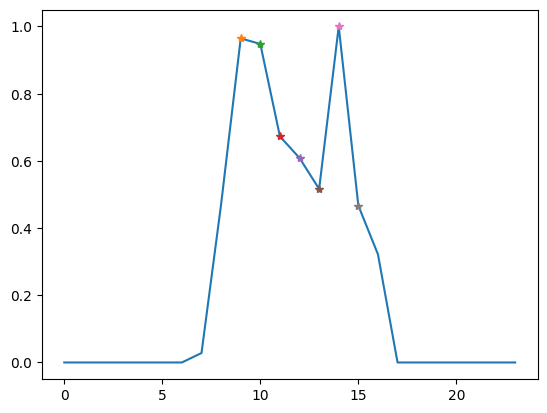

In [15]:
n = 200
plt.plot(x_test[n])
for indice, elemento in enumerate(y_test[n]):
    if elemento == 1:
        plt.plot(indice, x_test[n][indice], '*')


Redes Neuronales

In [61]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.regularizers import l2
from keras.initializers import he_normal
from keras.optimizers import Adam
nadam_optimizer = Nadam(learning_rate=0.002)

In [64]:
# Crear una capa de entrada
optimizer = Adam(learning_rate = 0.1)
input_layer = Input(shape=(36,))

hidden_layer = Dense(16, activation='relu', kernel_initializer=he_normal)(input_layer)
#hidden_layer = Dense(36, activation='relu', kernel_initializer=he_normal)(hidden_layer)
#hidden_layer = Dense(36, activation='relu', kernel_initializer=he_normal)(hidden_layer)
#regularized_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(hidden_layer)
#dropout_layer = Dropout(0.5)(regularized_layer)
#output_layer = Dense(24, activation='softmax')(dropout_layer)
output_layer = Dense(18, activation='softmax')(hidden_layer)

# Crear el modelo de red neuronal
model = Model(inputs=input_layer, outputs=output_layer)

# Compilar el modelo
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 36)]              0         
                                                                 
 dense_36 (Dense)            (None, 16)                592       
                                                                 
 dense_37 (Dense)            (None, 18)                306       
                                                                 
Total params: 898 (3.51 KB)
Trainable params: 898 (3.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
history = model.fit( x_train_flat, np.array(y_train), epochs=50, batch_size=32, validation_data = (x_test_flat, np.array(y_test)) )

Epoch 1/50
1500/1500 [==============================] - 4s 2ms/step - loss: 0.1123 - accuracy: 0.0504 - val_loss: 0.1050 - val_accuracy: 0.0779
Epoch 2/50
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1034 - accuracy: 0.0482 - val_loss: 0.0928 - val_accuracy: 0.0547
Epoch 3/50
1112/1500 [=====================>........] - ETA: 0s - loss: 0.1032 - accuracy: 0.0511

KeyboardInterrupt: 

In [35]:
np.array(x_train_flat).shape

(47978, 36)

PCA

In [24]:
from sklearn.decomposition import PCA

# Especificar el número de componentes principales deseados (menor dimensionalidad)
n_components = 30  # Cambia este valor según tus necesidades

# Crear una instancia de PCA
pca = PCA(n_components=n_components)

# Ajustar el modelo PCA a tus datos
pca.fit(x_train_flat)

# Transformar tus datos a un espacio de menor dimensionalidad
data_reduced = pca.transform(x_train_flat)
datat_reduced = pca.transform(x_test_flat)

# Los datos reducidos ahora tienen menos dimensiones (2 en este ejemplo)
print("Datos originales de tamaño:", x_train_flat.shape)
print("Datos reducidos de tamaño:", data_reduced.shape)

Datos originales de tamaño: (47978, 36)
Datos reducidos de tamaño: (47978, 30)


In [25]:
modelo = RandomForestClassifier(n_estimators = 70, min_samples_split = 9, min_samples_leaf = 1, max_depth = None, bootstrap = False)
modelo = modelo.fit(data_reduced, y_train)
prediccion = modelo.predict(datat_reduced)

print(accuracy_score(prediccion, y_test))
print("")

lista1 = error_threshold(prediccion, y_test, 1)
lista2 = error_threshold(prediccion, y_test, 2)
prediccion = modelo.predict(datat_reduced)
pre = accuracy_score(prediccion, y_test)

print("total de predicciones:", len(x_test))
print("Total de vector con 1 error:", len(lista1[1]))
print("Total de vector con 2 error:", len(lista2[1]))
print("")

print("Precision con 1 error:", (len(lista1[1]) + pre*len(x_test))/len(x_test))
print("Precision con 2 error:", (len(lista1[1]) + len(lista2[1]) + pre*len(x_test))/len(x_test))

0.7492461822779886

total de predicciones: 20562
Total de vector con 1 error: 4107
Total de vector con 2 error: 879

Precision con 1 error: 0.94898356191032
Precision con 2 error: 0.9917323217585838


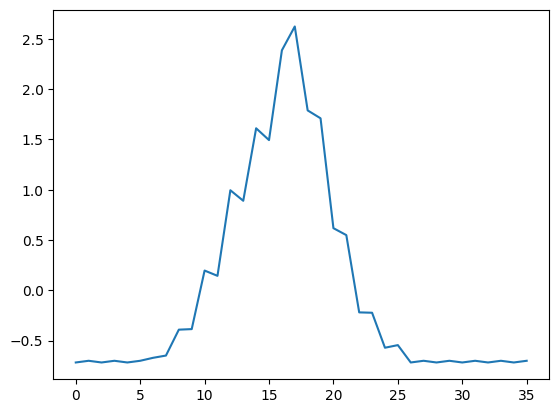

In [82]:
plt.plot(x_train_flat[2])